<a href="https://colab.research.google.com/github/alaa-32/Discovering-Rare-Genomic-Subtypes-from_RNA-seq/blob/main/Within_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# Libraries
!pip -q install umap-learn statsmodels --upgrade

from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import os
import matplotlib.pyplot as plt
from scipy.special import comb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
import umap
from scipy import stats
from statsmodels.stats.multitest import multipletests

# Reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE


device(type='cpu')

In [ ]:
df1 = pd.read_csv("/content/data.csv")
print(df1.shape)
df1

(801, 20532)


,Unnamed: 0,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.000000
1,sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.000000
2,sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.000000
3,sample_3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.000000
4,sample_4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,sample_796,0.0,1.865642,2.718197,7.350099,10.006003,0.0,6.764792,0.496922,0.0,...,6.088133,9.118313,10.004852,4.484415,9.614701,12.031267,9.813063,10.092770,8.819269,0.000000
797,sample_797,0.0,3.942955,4.453807,6.346597,10.056868,0.0,7.320331,0.000000,0.0,...,6.371876,9.623335,9.823921,6.555327,9.064002,11.633422,10.317266,8.745983,9.659081,0.000000
798,sample_798,0.0,3.249582,3.707492,8.185901,9.504082,0.0,7.536589,1.811101,0.0,...,5.719386,8.610704,10.485517,3.589763,9.350636,12.180944,10.681194,9.466711,4.677458,0.586693
799,sample_799,0.0,2.590339,2.787976,7.318624,9.987136,0.0,9.213464,0.000000,0.0,...,5.785237,8.605387,11.004677,4.745888,9.626383,11.198279,10.335513,10.400581,5.718751,0.000000


In [ ]:
df2 = pd.read_csv("/content/labels.csv")
print(df2.shape)
df2

(801, 2)


,Unnamed: 0,Class
0,sample_0,PRAD
1,sample_1,LUAD
2,sample_2,PRAD
3,sample_3,PRAD
4,sample_4,BRCA
...,...,...
796,sample_796,BRCA
797,sample_797,LUAD
798,sample_798,COAD
799,sample_799,PRAD


In [ ]:
# Identify shared ID column
common_cols = list(set(df1.columns).intersection(df2.columns))
assert len(common_cols) > 0, "No common ID column found between data.csv and labels.csv"
ID_COL = "Unnamed: 0" if "Unnamed: 0" in common_cols else common_cols[0]

# Align by ID using an inner merge to keep only common sample IDs
merged_df = pd.merge(df1, df2, on=ID_COL, how='inner')

# Separate sample IDs from features and labels
X_df = merged_df.set_index(ID_COL).drop(columns=['Class']).copy()
Y_df = merged_df.set_index(ID_COL)['Class'].to_frame().copy()


# Keep only numeric gene columns
X_df = X_df.select_dtypes(include=[np.number])

print("Samples:", X_df.shape[0], "Genes:", X_df.shape[1])
X_df.head(3)

Samples: 801 Genes: 20531


,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0


In [ ]:
# ===== Within-cancer selection =====
CANCER = "KIRC"
import pandas as pd
X_all = X_df if 'X_df' in globals() else X_full
Y_all = Y_df if 'Y_df' in globals() else y_full

mask  = Y_all["Class"].eq(CANCER)
X_use = X_all.loc[mask].copy()
y_use = Y_all.loc[mask].copy()

print(f"{CANCER} selected | n={X_use.shape[0]}")


KIRC selected | n=146


In [ ]:
# ===== HVGs + scaling on the selected cancer =====
import numpy as np
from sklearn.preprocessing import StandardScaler

TOP_HVG = 2000

gene_var  = X_use.var(0).replace([np.inf, -np.inf], np.nan).fillna(0.0)
top_genes = gene_var.sort_values(ascending=False).head(min(TOP_HVG, (gene_var>0).sum())).index.tolist()

X_mat  = X_use[top_genes].values
scaler = StandardScaler()
Xz     = scaler.fit_transform(X_mat)

samples = X_use.index.to_list()
genes   = top_genes
print("Xz shape:", Xz.shape)


Xz shape: (146, 2000)


## Build PyTorch Dataset & Dataloader

In [ ]:
class GeneDataset(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = torch.tensor(X, dtype=torch.float32)
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, i):
        return self.X[i]

# Split train/val
from sklearn.model_selection import train_test_split
SEED = 42 # Define SEED
X_tr, X_va = train_test_split(Xz, test_size=0.15, random_state=SEED)

train_ds = GeneDataset(X_tr)
val_ds   = GeneDataset(X_va)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=256, shuffle=True, num_workers=2, pin_memory=True)
val_dl   = torch.utils.data.DataLoader(val_ds,   batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

len(train_ds), len(val_ds)

(124, 22)

# Define the Autoencoder Architecture+Training Setup

In [ ]:
D_IN = Xz.shape[1]
LATENT = 128  # as requested
H1 = min(1024, max(256, D_IN//2))
H2 = min(512,  max(128, D_IN//4))

class AutoEncoder(nn.Module):
    def __init__(self, d_in, h1, h2, d_lat):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(d_in, h1), nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(h1, h2), nn.ReLU(),
            nn.Linear(h2, d_lat)
        )
        self.dec = nn.Sequential(
            nn.Linear(d_lat, h2), nn.ReLU(),
            nn.Linear(h2, h1), nn.ReLU(),
            nn.Linear(h1, d_in)
        )
    def forward(self, x):
        z = self.enc(x)
        out = self.dec(z)
        return out, z

ae = AutoEncoder(D_IN, H1, H2, LATENT).to(DEVICE)
opt = torch.optim.Adam(ae.parameters(), lr=1e-3, weight_decay=1e-5)
crit = nn.MSELoss()

# Train Autoencoder

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 001: train 0.9600 | val 1.2265
Epoch 005: train 0.8981 | val 1.0163
Epoch 010: train 0.7258 | val 0.9628
Epoch 015: train 0.6210 | val 0.9007
Epoch 020: train 0.5412 | val 0.8504
Epoch 025: train 0.4777 | val 0.8290
Epoch 030: train 0.4189 | val 0.8079
Epoch 035: train 0.3615 | val 0.8044
Epoch 040: train 0.3077 | val 0.7979
Epoch 045: train 0.2553 | val 0.8017
Epoch 050: train 0.2079 | val 0.8165
Epoch 055: train 0.1623 | val 0.8234
Early stopping.


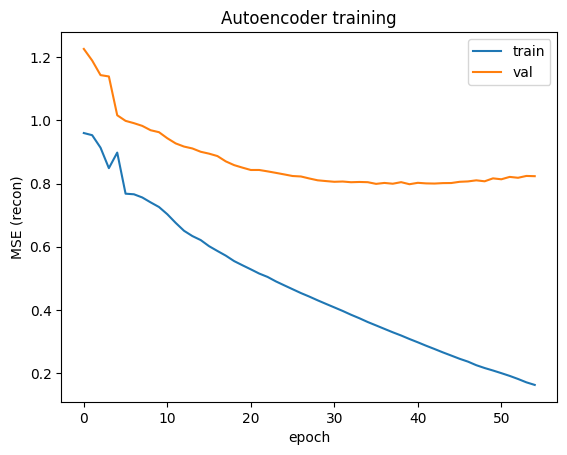

In [ ]:
EPOCHS = 100
PATIENCE = 15

best_val = np.inf
best_state = None
no_improve = 0
tr_hist, va_hist = [], []

for ep in range(1, EPOCHS+1):
    # train
    ae.train()
    tl = 0.0
    for xb in train_dl:
        xb = xb.to(DEVICE, non_blocking=True)
        opt.zero_grad()
        recon, _ = ae(xb)
        loss = crit(recon, xb)
        loss.backward()
        opt.step()
        tl += loss.item() * xb.size(0)
    tl /= len(train_ds)

    # val
    ae.eval()
    vl = 0.0
    with torch.no_grad():
        for xb in val_dl:
            xb = xb.to(DEVICE, non_blocking=True)
            recon, _ = ae(xb)
            loss = crit(recon, xb)
            vl += loss.item() * xb.size(0)
    vl /= len(val_ds)

    tr_hist.append(tl); va_hist.append(vl)

    if vl < best_val - 1e-6:
        best_val = vl
        best_state = ae.state_dict()
        no_improve = 0
    else:
        no_improve += 1

    if ep % 5 == 0 or ep == 1:
        print(f"Epoch {ep:03d}: train {tl:.4f} | val {vl:.4f}")

    if no_improve >= PATIENCE:
        print("Early stopping.")
        break

# Load best
if best_state is not None:
    ae.load_state_dict(best_state)

# Plot learning curve
plt.plot(tr_hist, label="train"); plt.plot(va_hist, label="val")
plt.xlabel("epoch"); plt.ylabel("MSE (recon)"); plt.title("Autoencoder training"); plt.legend(); plt.show()


In [ ]:
# ==== Embed ALL samples to latent Z for clustering ====
ae.eval()
with torch.no_grad():
    X_tensor = torch.tensor(Xz, dtype=torch.float32, device=DEVICE)
    _, Z = ae(X_tensor)
    Z = Z.cpu().numpy()

print("Latent Z shape:", Z.shape)

Latent Z shape: (146, 128)


# Cluster the Latent Space

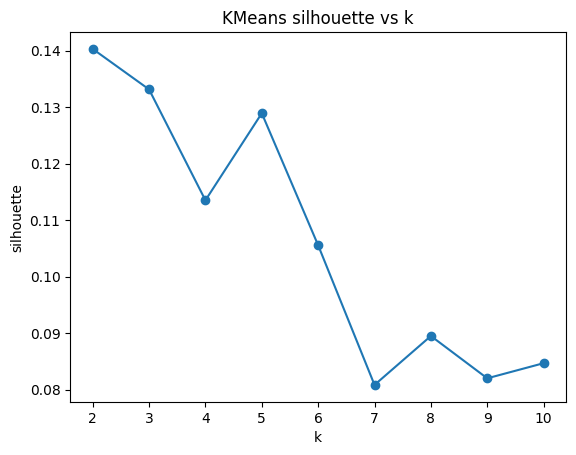

Best k = 2 (silhouette=0.140)


,size,rare
cluster,,
0,69,False
1,77,False


In [ ]:
Ks = list(range(2, 11))
sils = []
fits = {}

for k in Ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=SEED)
    lab = km.fit_predict(Z)
    s = silhouette_score(Z, lab)
    sils.append(s); fits[k] = (km, lab)

plt.plot(Ks, sils, marker="o")
plt.xlabel("k"); plt.ylabel("silhouette"); plt.title("KMeans silhouette vs k")
plt.show()

best_k = Ks[int(np.argmax(sils))]
km, km_labels = fits[best_k]
print(f"Best k = {best_k} (silhouette={max(sils):.3f})")

clusters = pd.Series(km_labels, index=X_use.index, name="cluster")
cluster_summary = clusters.value_counts().sort_index().to_frame("size")
rare_threshold = max(1, int(0.05 * len(clusters)))  # ≤5% cohort = rare
cluster_summary["rare"] = cluster_summary["size"] <= rare_threshold
cluster_summary

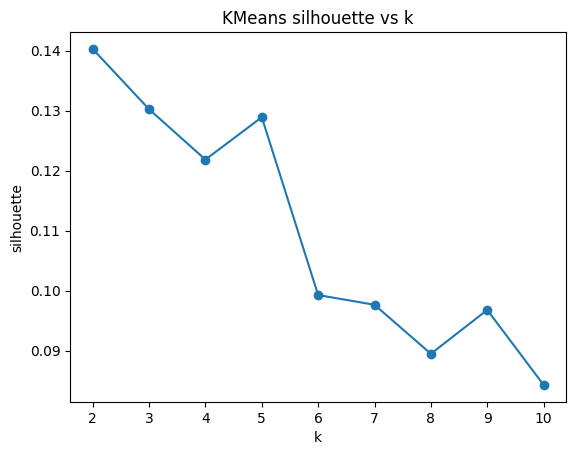

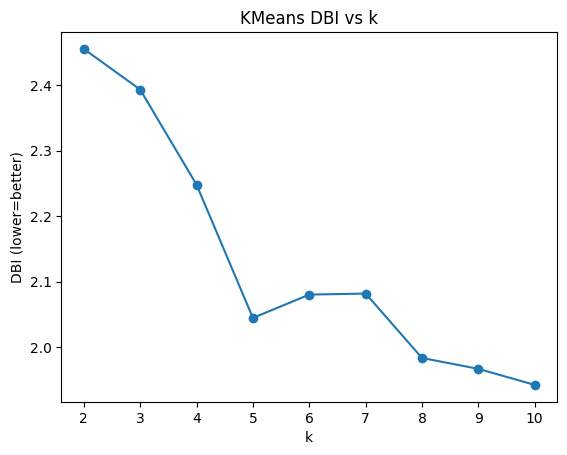

Best k = 2 | silhouette=0.140 | DBI=2.455


,size,prevalence,rare
cluster,,,
0,69,0.472603,False
1,77,0.527397,False


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

Ks   = list(range(2, 11))
sils = []
dbis = []
fits = {}

for k in Ks:
    km  = KMeans(n_clusters=k, n_init=30, random_state=SEED)
    lab = km.fit_predict(Z)                 # Z is your AE latent
    sil = silhouette_score(Z, lab)
    dbi = davies_bouldin_score(Z, lab)
    sils.append(sil); dbis.append(dbi)
    fits[k] = (km, lab)

# plots
plt.plot(Ks, sils, marker="o"); plt.xlabel("k"); plt.ylabel("silhouette"); plt.title("KMeans silhouette vs k"); plt.show()
plt.plot(Ks, dbis, marker="o"); plt.xlabel("k"); plt.ylabel("DBI (lower=better)"); plt.title("KMeans DBI vs k"); plt.show()

best_k = Ks[int(np.argmax(sils))]           # pick by silhouette (you can also trade off with DBI)
km, km_labels = fits[best_k]
print(f"Best k = {best_k} | silhouette={max(sils):.3f} | DBI={dbis[Ks.index(best_k)]:.3f}")

clusters = pd.Series(km_labels, index=X_use.index, name="cluster")
cluster_summary = clusters.value_counts().sort_index().to_frame("size")
rare_threshold = int(0.10 * len(clusters))   # <10% = rare (paper rule)
cluster_summary["prevalence"] = cluster_summary["size"] / len(clusters)
cluster_summary["rare"] = cluster_summary["prevalence"] < 0.10
cluster_summary


In [ ]:
# Scan stability across k and find rare & stable clusters
import numpy as np, pandas as pd
from sklearn.cluster import KMeans
from scipy.optimize import linear_sum_assignment

def relabel_with_hungarian(lab_ref, lab_pred):
    A = pd.crosstab(lab_ref, lab_pred)
    cost = A.max().sum() - A.values
    r,c = linear_sum_assignment(cost)
    mapping = {A.index[i]: A.columns[j] for i,j in zip(r,c)}
    return np.array([mapping.get(x, x) for x in lab_pred])

def kmeans_stability(Z, k, runs=20, seed=42):
    labs=[]
    for s in range(runs):
        km = KMeans(k, n_init=10, random_state=seed+s).fit(Z)
        labs.append(km.labels_)
    labs=np.array(labs)
    aligned=[labs[0]]
    for r in range(1,labs.shape[0]):
        aligned.append(relabel_with_hungarian(labs[0], labs[r]))
    aligned=np.vstack(aligned)
    ref=aligned[0]
    jacc={}
    for c in np.unique(ref):
        idx=(ref==c); vals=[]
        for r in range(aligned.shape[0]):
            best=0.0
            for cp in np.unique(aligned[r]):
                idxp=(aligned[r]==cp)
                inter=(idx & idxp).sum(); union=(idx | idxp).sum()
                best=max(best, inter/max(1,union))
            vals.append(best)
        jacc[c]=float(np.mean(vals))
    return jacc

rows=[]
for k in range(3, 11):  # start at 3 to allow a <10% cluster more plausibly
    km = KMeans(k, n_init=30, random_state=SEED).fit(Z)
    lab = km.labels_
    sizes = pd.Series(lab).value_counts().sort_index()
    prev  = sizes / sizes.sum()
    jacc  = kmeans_stability(Z, k, runs=20, seed=SEED)
    for c in sizes.index:
        rows.append({
            "k": k, "cluster": int(c),
            "size": int(sizes[c]),
            "prevalence": float(prev[c]),
            "stability_jaccard": float(jacc.get(int(c), np.nan))
        })

stab_grid = pd.DataFrame(rows).assign(
    is_rare_lt10=lambda d: d["prevalence"] < 0.10,
    is_stable_ge60=lambda d: d["stability_jaccard"] >= 0.60
)
display(stab_grid.sort_values(["k","cluster"]))

# Choose the smallest k that has a rare & stable cluster
cands = stab_grid.query("is_rare_lt10 and is_stable_ge60").sort_values(["k","stability_jaccard"], ascending=[True, False])
display(cands.head(10))


,k,cluster,size,prevalence,stability_jaccard,is_rare_lt10,is_stable_ge60
0,3,0,44,0.301370,0.643374,False,True
1,3,1,39,0.267123,0.815253,False,True
2,3,2,63,0.431507,0.483705,False,False
3,4,0,54,0.369863,0.664868,False,True
4,4,1,28,0.191781,0.784322,False,True
5,4,2,37,0.253425,0.434025,False,False
6,4,3,27,0.184932,0.780734,False,True
7,5,0,10,0.068493,0.787439,True,True
8,5,1,19,0.130137,0.617326,False,True
9,5,2,31,0.212329,0.439997,False,False


,k,cluster,size,prevalence,stability_jaccard,is_rare_lt10,is_stable_ge60
7,5,0,10,0.068493,0.787439,True,True
30,8,5,11,0.075342,0.810227,True,True
49,10,7,12,0.082192,0.786322,True,True
51,10,9,10,0.068493,0.624416,True,True


#  Refit K-Means at k=5 and fix labels

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np, pandas as pd

K_FINAL = 5
km5 = KMeans(n_clusters=K_FINAL, n_init=30, random_state=SEED).fit(Z)
lab5 = km5.labels_

sil5 = silhouette_score(Z, lab5)
dbi5 = davies_bouldin_score(Z, lab5)
sizes5 = pd.Series(lab5).value_counts().sort_index()
prev5  = (sizes5 / sizes5.sum()).round(4)

print(f"k=5 | silhouette={sil5:.3f} | DBI={dbi5:.3f}")
display(pd.DataFrame({"size": sizes5, "prevalence": prev5}))


k=5 | silhouette=0.129 | DBI=2.045


,size,prevalence
0,10,0.0685
1,19,0.1301
2,31,0.2123
3,53,0.3630
4,33,0.2260


In [ ]:
from scipy.stats import ttest_ind
import statsmodels.stats.multitest as smm

labels = pd.Series(lab5, index=X_use.index, name="cluster")
expr   = pd.DataFrame(Xz, index=X_use.index, columns=genes)

TARGET = 0  # rare cluster id at k=5

def de_cluster_vs_rest(expr_z, labels, target_cluster):
    in_c  = labels.eq(target_cluster).values
    out_c = ~in_c
    eff   = expr_z.values[in_c].mean(axis=0) - expr_z.values[out_c].mean(axis=0)          # Δz
    t, p  = ttest_ind(expr_z.values[in_c], expr_z.values[out_c], axis=0, equal_var=False, nan_policy="omit")
    _, fdrv, _, _ = smm.multipletests(p, method="fdr_bh")
    df = pd.DataFrame({"gene": expr_z.columns, "effect": eff, "p": p, "fdr": fdrv}).sort_values(["fdr","effect"], ascending=[True, False])
    return df

markers_c0 = de_cluster_vs_rest(expr, labels, TARGET)
markers_c0_top = markers_c0.head(50)
OUT = "/content/outputs"
import os; os.makedirs(OUT, exist_ok=True)
markers_c0.to_csv(f"{OUT}/markers_k{K_FINAL}_c{TARGET}.csv", index=False)
markers_c0_top.head(15)


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:611: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


,gene,effect,p,fdr
1135,gene_3777,-1.459300,6.339783e-31,1.267957e-27
604,gene_274,-1.050242,3.383107e-23,2.734738e-20
355,gene_8185,-1.385814,4.102108e-23,2.734738e-20
30,gene_2715,-1.012708,1.802732e-21,9.013658e-19
25,gene_5659,-1.178358,5.864820e-16,2.345928e-13
264,gene_17397,1.350746,1.750901e-14,5.836338e-12
104,gene_13678,-2.012104,2.835216e-14,8.100616e-12
1275,gene_2760,1.130763,1.815131e-13,4.537829e-11
31,gene_17009,-1.405763,4.105611e-13,9.123580e-11
1322,gene_9561,-0.755469,6.569165e-13,1.313833e-10


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


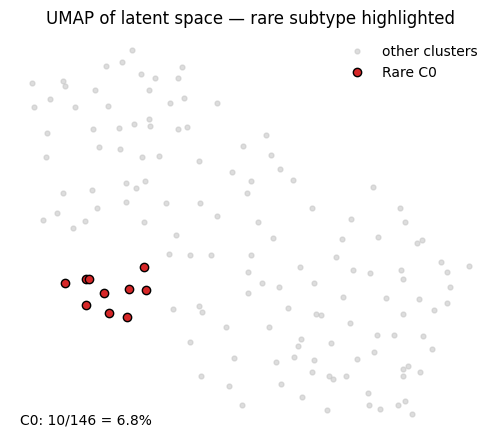

In [ ]:
import umap, numpy as np, matplotlib.pyplot as plt

TARGET = 0  # rare cluster at k=5
U = umap.UMAP(n_neighbors=15, min_dist=0.3, random_state=SEED).fit_transform(Z)
c = np.array(lab5)

plt.figure(figsize=(6.2,5.2))
# background (all others)
mask_other = c != TARGET
plt.scatter(U[mask_other,0], U[mask_other,1], s=12, c="#c7c7c7", alpha=0.6, label="other clusters")
# rare subtype with halo
plt.scatter(U[~mask_other,0], U[~mask_other,1], s=36, c="#d62728", edgecolors="black", linewidths=1.0, label=f"Rare C{TARGET}")
plt.title("UMAP of latent space — rare subtype highlighted")
plt.axis("off"); plt.legend(loc="best", frameon=False)
# annotate size/prevalence
n = (~mask_other).sum(); N = len(c)
plt.text(0.02, 0.02, f"C{TARGET}: {n}/{N} = {100*n/N:.1f}%", transform=plt.gca().transAxes)
plt.show()


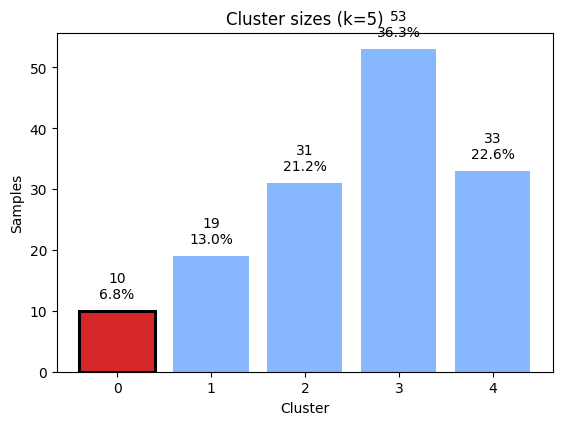

In [ ]:
counts = pd.Series(lab5).value_counts().sort_index()
prev   = (counts / counts.sum() * 100).round(1)

fig, ax = plt.subplots(figsize=(6.4,4.4))
bars = ax.bar(counts.index, counts.values, color="#86b7ff")
bars[TARGET].set_color("#d62728")
bars[TARGET].set_linewidth(2.2)
bars[TARGET].set_edgecolor("black")
ax.set_xlabel("Cluster"); ax.set_ylabel("Samples"); ax.set_title("Cluster sizes (k=5)")
for i, v in enumerate(counts.values):
    ax.text(i, v + max(counts.values)*0.03, f"{int(v)}\n{prev.iloc[i]}%", ha="center", va="bottom", fontsize=10)
plt.show()



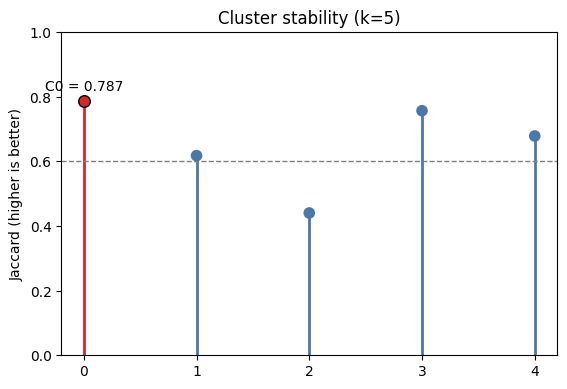

In [ ]:
import pandas as pd, matplotlib.pyplot as plt, numpy as np

stab_k5 = stab_grid.query("k==5")[["cluster","stability_jaccard"]].sort_values("cluster")
x = stab_k5["cluster"].values
y = stab_k5["stability_jaccard"].values

plt.figure(figsize=(6.4,4.2))
for xi, yi in zip(x, y):
    col = "#d62728" if xi==TARGET else "#4c78a8"
    plt.plot([xi, xi], [0, yi], color=col, lw=2)
    plt.scatter([xi], [yi], s=70, color=col, edgecolor="black" if xi==TARGET else "none", zorder=3)
plt.axhline(0.60, ls="--", lw=1, color="gray")
plt.xticks(x)
plt.ylim(0, 1.0)
plt.ylabel("Jaccard (higher is better)")
plt.title("Cluster stability (k=5)")
plt.text(TARGET, y[list(x).index(TARGET)] + 0.03, f"C{TARGET} = {y[list(x).index(TARGET)]:.3f}", ha="center")
plt.show()


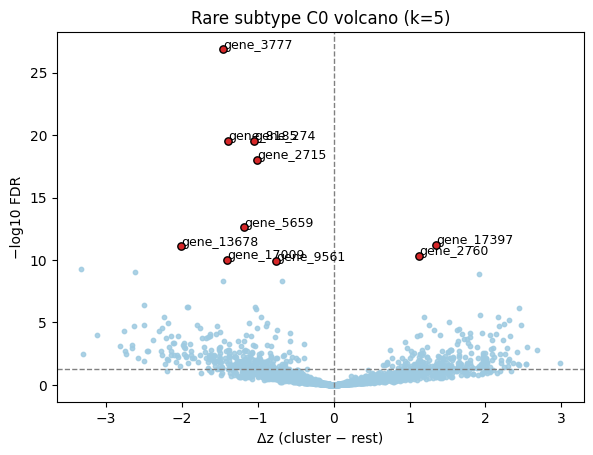

In [ ]:

m = markers_c0.copy()
m["neglog10FDR"] = -np.log10(m["fdr"] + 1e-300)

plt.figure(figsize=(6.8,4.8))
plt.scatter(m["effect"], m["neglog10FDR"], s=10, c="#9ecae1", alpha=0.85)
plt.axvline(0, ls="--", lw=1, color="gray"); plt.axhline(-np.log10(0.05), ls="--", lw=1, color="gray")
plt.xlabel("Δz (cluster − rest)"); plt.ylabel("−log10 FDR"); plt.title(f"Rare subtype C{TARGET} volcano (k=5)")

labN = 10
for _, r in m.nsmallest(labN, "fdr").iterrows():
    plt.scatter(r["effect"], r["neglog10FDR"], s=28, c="#d62728", edgecolors="black", zorder=4)
    plt.text(r["effect"], r["neglog10FDR"]+0.05, r["gene"], fontsize=9)
plt.show()


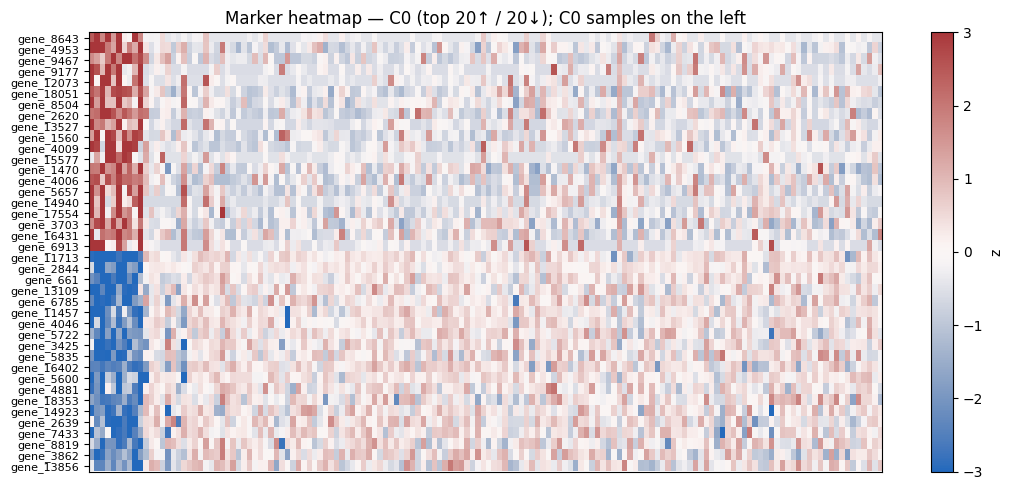

In [ ]:
import seaborn as sns
expr_z   = pd.DataFrame(Xz, index=X_use.index, columns=genes)
labels_s = pd.Series(lab5, index=X_use.index, name="cluster")

mm = markers_c0.copy()
up_genes   = mm.sort_values("effect", ascending=False).head(20)["gene"].tolist()
down_genes = mm.sort_values("effect", ascending=True ).head(20)["gene"].tolist()
sel_genes  = up_genes + down_genes

# order: rare samples first
order_idx = np.r_[np.where(labels_s.values==TARGET)[0], np.where(labels_s.values!=TARGET)[0]]
M = expr_z.loc[labels_s.index[order_idx], sel_genes].clip(-3, 3)

plt.figure(figsize=(11,5))
plt.imshow(M.T, aspect="auto", cmap="vlag", interpolation="nearest")
plt.colorbar(label="z")
plt.yticks(range(len(sel_genes)), sel_genes, fontsize=8)
plt.xticks([], [])
plt.title(f"Marker heatmap — C{TARGET} (top 20↑ / 20↓); C{TARGET} samples on the left")
plt.tight_layout(); plt.show()
